# ZFOURGE Luminosity Functions Notebook

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

# Settings
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(8, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

## Mask Data

In [18]:
# Get data
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN8.csv', index_col=['Seq'])
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN8.csv', index_col=['Seq'])
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN8.csv', index_col=['Seq'])

# Combine data
df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
print(f'Number of sources: {len(df)}')

# Use Mask
df = df[df['Use'] == 1]
print(f'Number of sources Use=1: {len(df)}')

#LIR Mask
df = df[df['LIR'] > 0]
print(f'Number of sources LIR>0: {len(df)}')

# Redshift Mask
z_mask = (df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])
df = df[z_mask]
print(f'Number of sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(df)}')

Number of sources: 73790
Number of sources Use=1: 37647
Number of sources LIR>0: 22997
Number of sources 0.0 <= z <= 6.0: 22967


### Luminosity

In [19]:
# Luminosity
luminosity = df['LIR'].copy() # solar luminosities
# luminosity = df['l_up'].copy() # Upper limit
# luminosity = df['l_down'].copy() # Lower limit
luminosity *= 3.828 * 10 ** 26 # solar luminosity -> Watts

# Redshift
z = df['zpk'].values # redshift
 
# Bolometric Flux completeness limit
Fbol_lim = 3.9598154104451116e-18 # W/m^2 - calculated as the 80% percentile of the bolometric fluxes (np.percentile(F_bol, 20))

### Maximum Observable Volume

In [20]:
all_data = []

for z_start, z_end in redshift_bins:
    mask_z = (z >= z_start) & (z < z_end)
        
    # Luminosity of galaxies in each redshift bin
    lum_bin = np.log10(luminosity[mask_z]/(3.83*10**26))
    
    # Minimum and maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmax = cosmo.comoving_distance(z_end).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask_z] / (4*np.pi*Fbol_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
        
    # Limit the maximum galaxy distance to the end of the redshift bin
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each galaxy
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    # Data
    all_data.append([vol, lum_bin])

## Completeness Limits

0.0 <= z < 0.3: [8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0]
0.3 <= z < 0.45: [9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25]
0.45 <= z < 0.6: [9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5]
0.6 <= z < 0.8: [9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75]
0.8 <= z < 1.0: [10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0]
1.0 <= z < 1.2: [10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0]
1.2 <= z < 1.7: [10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5]
1.7 <= z < 2.0: [10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75]
2.0 <= z < 2.5: [10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75]
2.5 <= z < 3.0: [11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75]
3.0 <= z < 4.2: [11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5]
4.2 <= z < 6.0: [12.25, 12.5, 12.75, 13.0, 13.25]


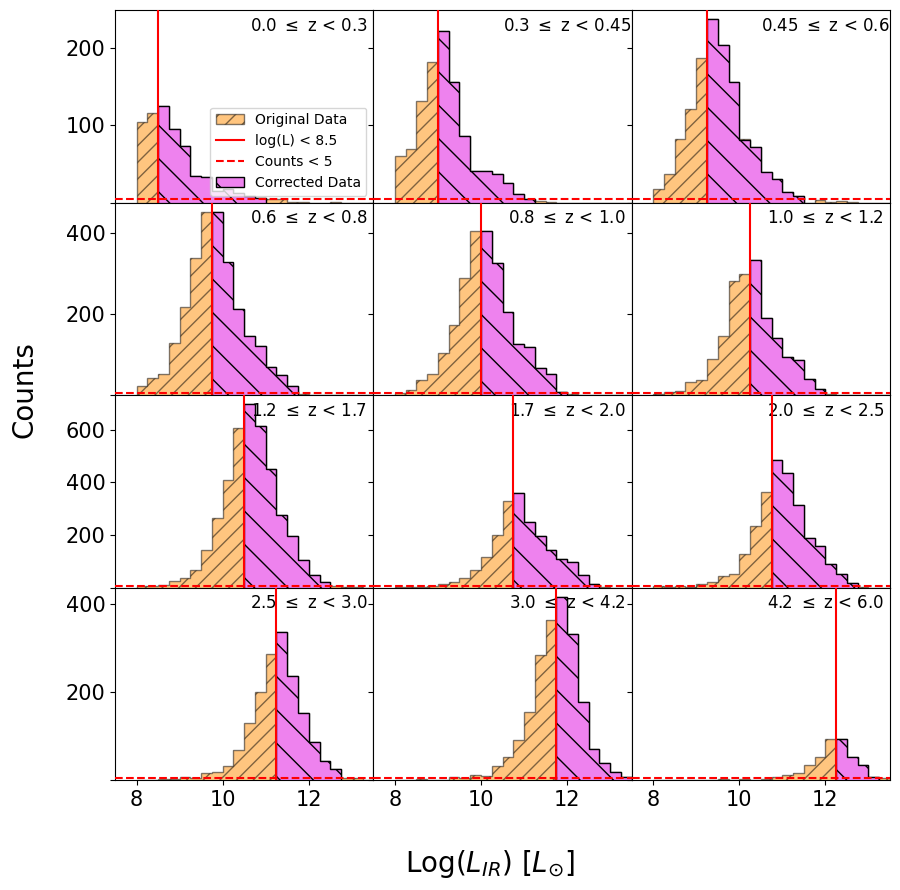

In [21]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey='row')
bin_edges = []

for i, (ax, (z_start, z_end), (vol, lum)) in enumerate(zip(axes.flatten(), redshift_bins, all_data)):
    mask_z = (z > z_start) & (z <= z_end)
    
    # Bin the original data per redshift bin
    c, b, _ = ax.hist(np.log10(luminosity/(3.83*10**26))[mask_z], 
        bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
    
    # Luminsity completeness limit
    l_lim = np.where(c == np.max(c))[0][0] # peak
    ax.axvline(b[l_lim], color='red', linestyle='-', label=f'log(L) < {b[l_lim]}', zorder=10)
    mask_l = b[1:] >= b[1:][l_lim-1]
    
    # Minimum  limit
    mask_c = c >= min_count
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}', zorder=10)
    
    # Bin the new data with the same bins
    try:
        c, b, _ = ax.hist(lum[lum >= b[l_lim]], bins=b[1:][mask_l & mask_c], histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True)
    except ValueError: # all bins are complete
        c, b, _ = ax.hist(lum[lum >= b[l_lim]], bins=b[:-1][mask_c], histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True)
        
    # Plot the new, corrected data
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', x=0.75, y=0.85, fontsize=12)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlim(7.5, 13.5)
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
    if i == 0:
        ax.legend(loc='lower right')
    bin_edges.append(b)
    print(f'{z_start} <= z < {z_end}: {b.tolist()}')

fig.supylabel('Counts', fontsize=20)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', fontsize=20)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Luminosity Function

In [22]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Calculate the luminosity bin width
    delta_log_l = np.diff(bin)[0]

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask_lum = (lum >= lum_start) & (lum < lum_end)
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol[mask_lum])
        
        # 1sigma poisson error
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol[mask_lum] ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(np.array(phi_z))
    phi_e.append(np.array(phi_e_z))


## Error Propagation

In [23]:
ZF_UP = np.load('fits/NEW_NEW_ZFOURGE_TOTAL_UPPER.npz', allow_pickle=True)
ZF_DN = np.load('fits/NEW_NEW_ZFOURGE_TOTAL_LOWER.npz', allow_pickle=True)
# ZF_UP = np.load('fits/BIG_ZFOURGE_TOTAL_UPPER.npz', allow_pickle=True)
# ZF_DN = np.load('fits/BIG_ZFOURGE_TOTAL_LOWER.npz', allow_pickle=True)

for i, (lum, p, e, up_lum, up_p, up_e, dn_lum, dn_p, dn_e) in enumerate(zip(lum_centers, phi, phi_e, ZF_UP['x'], ZF_UP['y'], ZF_UP['e'], ZF_DN['x'], ZF_DN['y'], ZF_DN['e'])):
    lum = np.array(lum)
    up_lum = np.array(up_lum)
    dn_lum = np.array(dn_lum)
    
    # Get only the overlapping luminosities
    _, idx_up, idx_dn = np.intersect1d(up_lum, dn_lum, return_indices=True)
    _, idx_up, idx = np.intersect1d(up_lum[idx_up], lum, return_indices=True)
    _, idx_up, idx_dn = np.intersect1d(up_lum[idx_up], dn_lum[idx_dn], return_indices=True)
    
    # Get the correct errors
    up_e = (up_p[idx_up] + up_e[idx_up]) - p[idx]
    dn_e = p[idx] - (dn_p[idx_dn] - dn_e[idx_dn])
    quad_err = np.sqrt(e[idx]**2 + up_e**2 + dn_e**2)
    
    # Save the corrected data
    lum_centers[i] = lum[idx]
    phi[i] = p[idx]
    phi_e[i] = quad_err

## Plot Luminosity Function

0.0 <= z < 0.3
[ 8.625  8.875  9.125  9.375  9.625  9.875 10.125 10.375 10.625]
[-1.58 -1.7  -1.82 -2.15 -2.16 -2.51 -2.43 -2.6  -2.78]
[0.12 0.13 0.13 0.4  0.13 0.53 0.17 0.35 0.45]


0.3 <= z < 0.45
[ 9.375  9.625  9.875 10.125 10.375 10.625 10.875]
[-1.79 -2.05 -2.37 -2.37 -2.41 -2.58 -2.94]
[0.22 0.51 0.64 0.08 0.1  0.36 0.68]


0.45 <= z < 0.6
[ 9.625  9.875 10.125 10.375 10.625 10.875 11.125]
[-1.89 -2.01 -2.29 -2.34 -2.61 -2.72 -3.09]
[0.13 0.2  0.47 0.05 0.52 0.21 0.73]


0.6 <= z < 0.8
[ 9.875 10.125 10.375 10.625 10.875 11.125 11.375 11.625]
[-1.83 -1.97 -2.16 -2.32 -2.41 -2.65 -2.8  -3.15]
[0.04 0.16 0.14 0.11 0.11 0.23 0.23 0.4 ]


0.8 <= z < 1.0
[10.125 10.375 10.625 10.875 11.125 11.375 11.625]
[-2.   -2.09 -2.3  -2.5  -2.53 -2.79 -2.89]
[0.07 0.11 0.2  0.2  0.07 0.34 0.15]


1.0 <= z < 1.2
[10.375 10.625 10.875 11.125 11.375 11.625 11.875]
[-2.16 -2.41 -2.53 -2.71 -2.75 -3.1  -3.48]
[0.05 0.26 0.11 0.1  0.07 0.57 0.4 ]


1.2 <= z < 1.7
[10.875 11.125 11.375 11.625 11.875

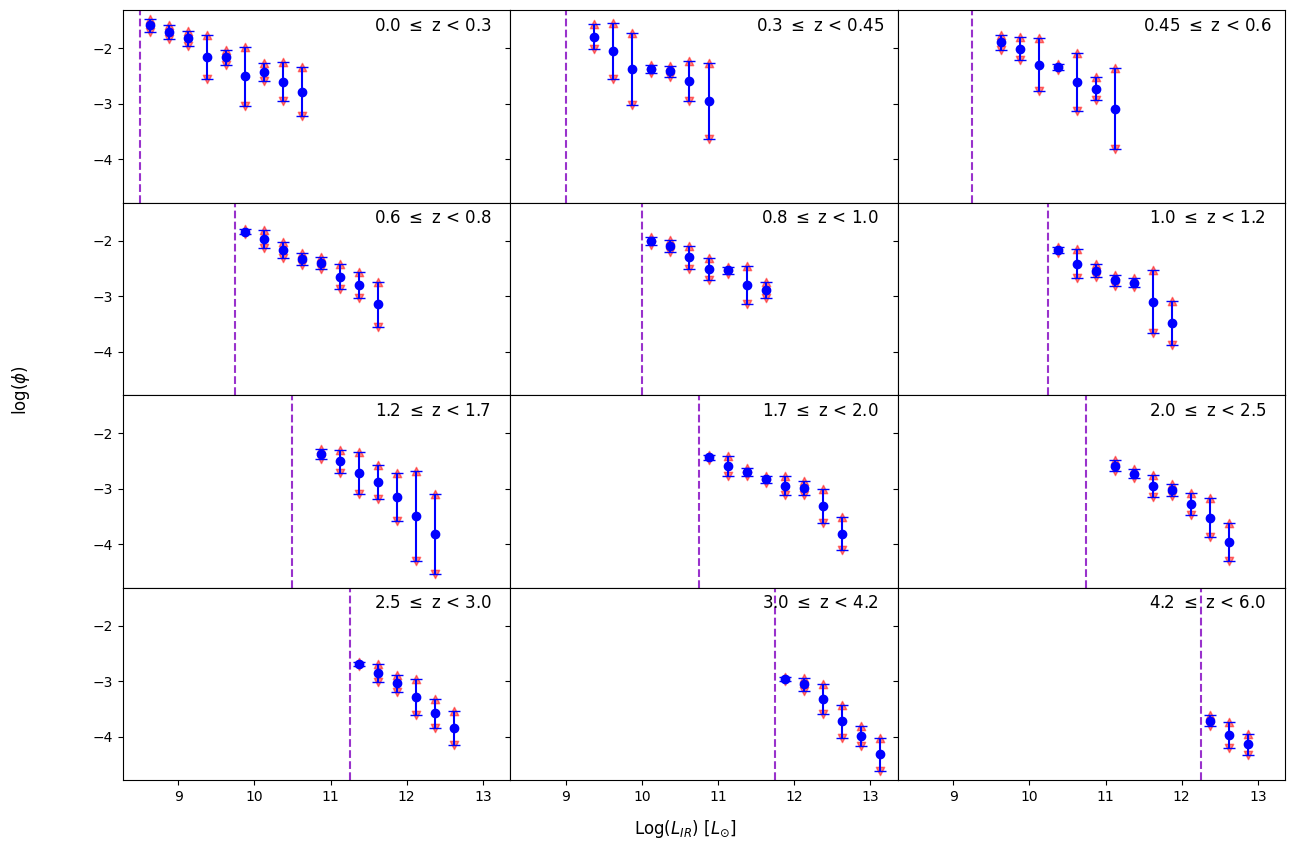

In [24]:
# Plot the data
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_l in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), bin_edges):
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', x=0.8, y=0.85, fontsize=12)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color='blue')
    ax.scatter(lum, np.log10(p)-yerr, marker='v', color='red', alpha=0.5)
    ax.scatter(lum, np.log10(p)+yerr, marker='^', color='red', alpha=0.5)
    ax.axvline(min_l[0], color='darkorchid', linestyle='--', label=f'Log(L) < {round(min_l[0], 2)}')

    # Print information
    print(f'{z_start} <= z < {z_end}')
    print(lum)
    print(np.round(np.log10(p),2))
    print(np.round(yerr,2))
    print('\n')

# """ ZFOURGE TOTAL """
# ZF_SF = np.load('fits/ZFOURGE_TOTAL.npz', allow_pickle=True)
# for i, (ax, l, p, e, (z_start, z_end)) in enumerate(zip(axes.flatten(), ZF_SF['x'], ZF_SF['y'], ZF_SF['e'], ZF_SF['z'])):
#     yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
#     ax.errorbar(l, np.log10(p), yerr=yerr, ls='none', marker='^', capsize=4, label='ZF TOTAL' if i == 0 else '', color='red')

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()   

## Fit Schechter Function

In [25]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []

for lum, p, e in zip(lum_centers, phi, phi_e):
    
    # Attempt to fit the data
    lum = np.power(10, lum)
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit error
    yerr = np.array(e) / (np.array(p) * np.log(10))
    p_up = np.power(10, np.log10(p) + yerr)
    p_dn = np.power(10, np.log10(p) - yerr)
    
    # Fit the data
    up_params, up_covars = curve_fit(schechter_luminosity, lum, p_up, p0=p0, bounds=bounds, maxfev=1000)
    params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000, sigma=e, absolute_sigma=True)
    dn_params, dn_covars = curve_fit(schechter_luminosity, lum, p_dn, p0=p0, bounds=bounds, maxfev=1000)
    
    # Calculate the errors
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    # Combine the errors
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    perr = np.sqrt(perr**2 + up_e**2 + dn_e**2)

    # Save the parameters and errors
    schecter_params.append(params)
    schecter_errors.append(perr)
    
    # print(np.log10(params) + (perr / (params * np.log(10))))
    # print(np.log10(params))
    # print(np.log10(params) - (perr / (params * np.log(10))))
    # print('.')
    
    # print(np.log10(params + perr))
    # print(np.log10(params))
    # print(np.log10(params - perr))
    # print(perr)
    # print('\n')

## Plot Schechter Function

0.0 <= z < 0.3:
Log L_star = 10.08 +/- 0.434
Log phi_star = -1.998 +/- 0.424
Alpha = 1.2


0.3 <= z < 0.45:
Log L_star = 10.861 +/- 0.714
Log phi_star = -2.41 +/- 3.013
Alpha = 1.2


0.45 <= z < 0.6:
Log L_star = 10.724 +/- 0.722
Log phi_star = -2.199 +/- 0.442
Alpha = 1.2


0.6 <= z < 0.8:
Log L_star = 10.924 +/- 0.45
Log phi_star = -2.039 +/- 0.133
Alpha = 1.2


0.8 <= z < 1.0:
Log L_star = 11.402 +/- 0.383
Log phi_star = -2.314 +/- 0.258
Alpha = 1.2


1.0 <= z < 1.2:
Log L_star = 11.364 +/- 0.744
Log phi_star = -2.381 +/- 0.194
Alpha = 1.2


1.2 <= z < 1.7:
Log L_star = 11.739 +/- 1.159
Log phi_star = -2.505 +/- 0.165
Alpha = 1.2


1.7 <= z < 2.0:
Log L_star = 12.224 +/- 0.21
Log phi_star = -2.765 +/- 0.131
Alpha = 1.2


2.0 <= z < 2.5:
Log L_star = 12.154 +/- 0.226
Log phi_star = -2.816 +/- 0.166
Alpha = 1.2


2.5 <= z < 3.0:
Log L_star = 12.154 +/- 0.37
Log phi_star = -2.787 +/- 0.125
Alpha = 1.2


3.0 <= z < 4.2:
Log L_star = 12.548 +/- 0.304
Log phi_star = -3.001 +/- 0.174
Alpha

C:\Users\danie\AppData\Local\Temp\ipykernel_15748\1608040610.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\danie\AppData\Local\Temp\ipykernel_15748\1608040610.py:25: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *param_up)),
C:\Users\danie\AppData\Local\Temp\ipykernel_15748\1608040610.py:26: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *param_dn)),


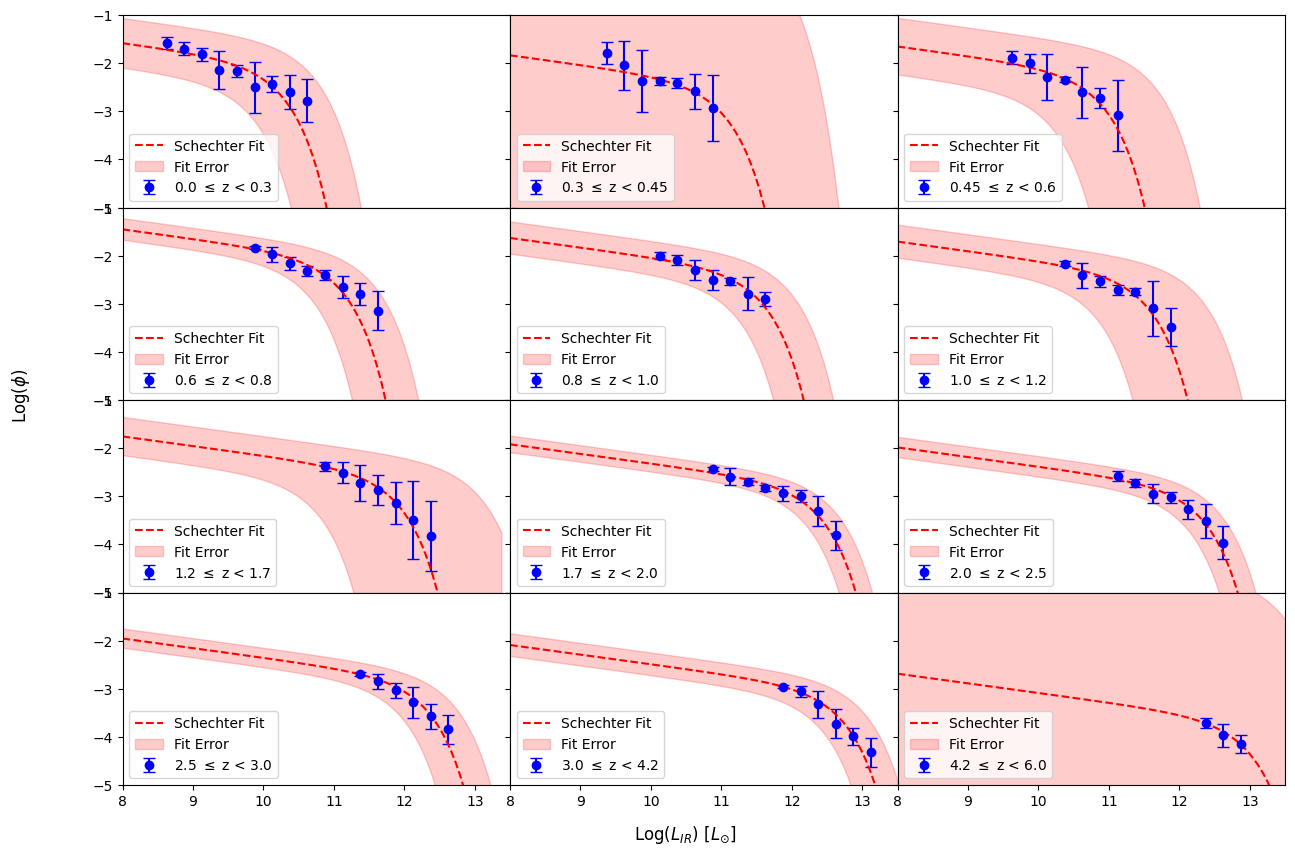

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, params, perr in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), schecter_params, schecter_errors):
    
    print(f'{z_start} <= z < {z_end}:')
    print(f'Log L_star = {np.round(np.log10(params[0]),3)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),3)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),3)} +/- {np.round((perr[1]) / (params[1] * np.log(10)),3)}')
    print(f'Alpha = 1.2')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color='blue')

    # Best fit
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    
    # Fit Error
    y_schech_err = np.array(perr) / (np.array(params) * np.log(10)) # it's cooked but it works
    param_up = np.power(10, np.log10(params) + y_schech_err)
    param_dn = np.power(10, np.log10(params) - y_schech_err)
    
    # Fill between the errors
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *param_up)),
        np.log10(schechter_luminosity(long_lum, *param_dn)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-5, -1)
    ax.set_xlim(8, 13.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Fit Saunders Function

In [27]:
def saunders_luminosity(L, L_star, phi_star, sigma):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
sigmas = [1.1, 1.0, 0.9, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

for lum, p, e, sigma in zip(lum_centers, phi, phi_e, sigmas):
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Fit error
    yerr = np.array(e) / (np.array(p) * np.log(10))
    p_up = np.power(10, np.log10(p) + yerr)
    p_dn = np.power(10, np.log10(p) - yerr)
        
    # Fit the data
    up_params, up_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_up, p0=p0, bounds=bounds, maxfev=10000)
    params, covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p, p0=p0, bounds=bounds, maxfev=10000, sigma=e, absolute_sigma=True)
    dn_params, dn_covars = curve_fit(lambda L, L_star, phi_star: saunders_luminosity(L, L_star, phi_star, sigma), lum, p_dn, p0=p0, bounds=bounds, maxfev=10000)
    
    up_perr = np.sqrt(np.diag(up_covars))
    perr = np.sqrt(np.diag(covars))
    dn_perr = np.sqrt(np.diag(dn_covars))
    
    up_e = (up_params + up_perr) - params
    dn_e = params - (dn_params - dn_perr)
    perr = np.sqrt(perr**2 + up_e**2 + dn_e**2)
    
    saunder_params.append(params)
    saunder_error.append(perr)

## Plot Saunders Function

0.0 <= z < 0.3 Function fit:
Log L_star = 8.5302 +/- 0.9698
Log phi_star = -1.5654 +/- 0.2951
Alpha = 1.3
Sigma = 1.1


0.3 <= z < 0.45 Function fit:
Log L_star = 9.6772 +/- 1.0529
Log phi_star = -2.1312 +/- 3.2698
Alpha = 1.3
Sigma = 1.0


0.45 <= z < 0.6 Function fit:
Log L_star = 9.4595 +/- 2.1208
Log phi_star = -1.8152 +/- 0.4039
Alpha = 1.3
Sigma = 0.9


0.6 <= z < 0.8 Function fit:
Log L_star = 9.9508 +/- 0.6003
Log phi_star = -1.8457 +/- 0.1177
Alpha = 1.3
Sigma = 0.8


0.8 <= z < 1.0 Function fit:
Log L_star = 10.564 +/- 0.4588
Log phi_star = -2.1563 +/- 0.1988
Alpha = 1.3
Sigma = 0.7


1.0 <= z < 1.2 Function fit:
Log L_star = 10.5065 +/- 0.8879
Log phi_star = -2.2093 +/- 0.2263
Alpha = 1.3
Sigma = 0.7


1.2 <= z < 1.7 Function fit:
Log L_star = 10.8312 +/- 2.2598
Log phi_star = -2.3174 +/- 0.2784
Alpha = 1.3
Sigma = 0.7


1.7 <= z < 2.0 Function fit:
Log L_star = 11.3219 +/- 0.5408
Log phi_star = -2.5944 +/- 0.1542
Alpha = 1.3
Sigma = 0.7


2.0 <= z < 2.5 Function fit:
Log L_

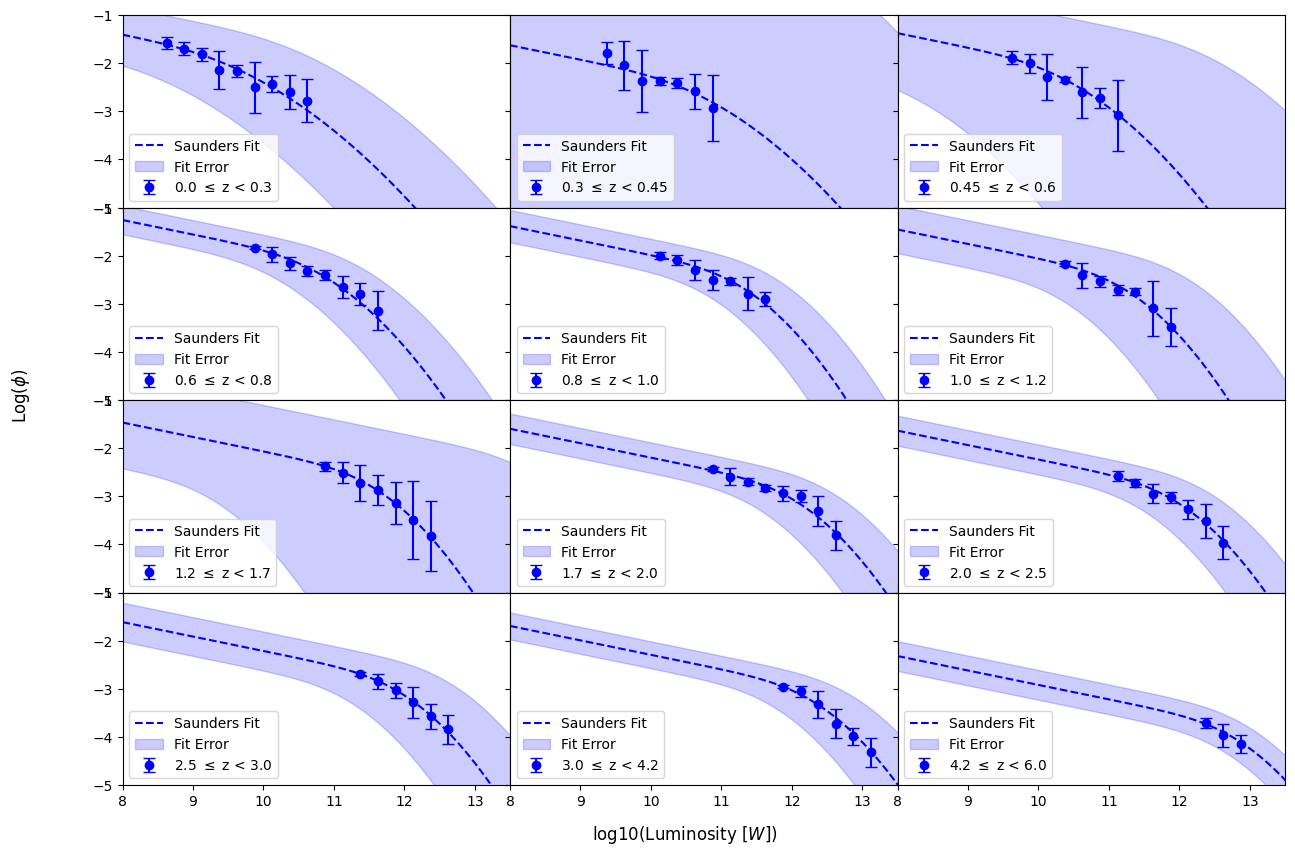

In [28]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, sigma, params, perr in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), sigmas, saunder_params, saunder_error):   
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),4)} +/- {np.round((perr[0]) / (params[0] * np.log(10)),4)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),4)} +/- {np.round((perr[1]) / (params[1] * np.log(10)),4)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = {sigma}')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = np.array(e) / (np.array(p) * np.log(10))
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4, color='blue')
    
    # Best Fit
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params, sigma)), color='blue', label='Saunders Fit', linestyle='--') 
    
    # Fit Error 
    y_schech_err = np.array(perr) / (np.array(params) * np.log(10)) # it's cooked but it works
    param_up = np.power(10, np.log10(params) + y_schech_err)
    param_dn = np.power(10, np.log10(params) - y_schech_err)
    
    # Fill between the errors
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *param_up, sigma)), 
        np.log10(saunders_luminosity(long_lum, *param_dn, sigma)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-5, -1)
    ax.set_xlim(8, 13.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Plot Parameter Evolution

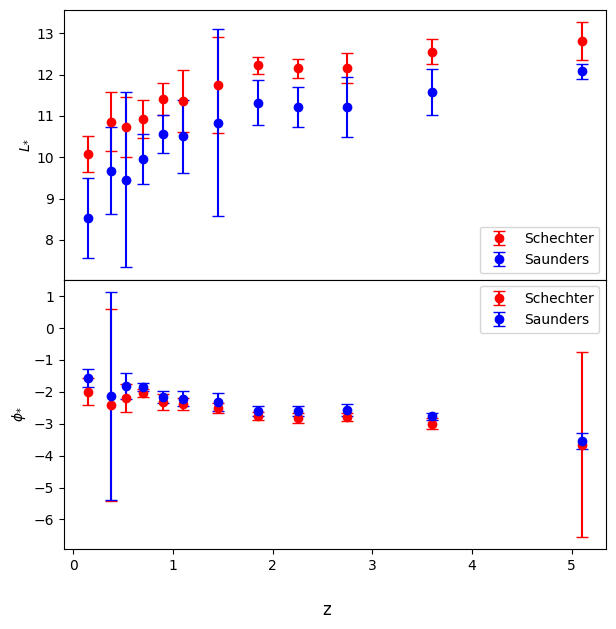

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
mean_z = np.mean(redshift_bins, axis=1)

ax[0].errorbar(mean_z, np.log10(np.array(schecter_params).T[0]), yerr=(np.array(schecter_errors).T[0] / (np.array(schecter_params).T[0] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[0].errorbar(mean_z, np.log10(np.array(saunder_params).T[0]), yerr=(np.array(saunder_error).T[0] / (np.array(saunder_params).T[0] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[0].set_ylabel('$L_{*}$')
ax[0].legend(loc='lower right')

ax[1].errorbar(mean_z, np.log10(np.array(schecter_params).T[1]), yerr=(np.array(schecter_errors).T[1] / (np.array(schecter_params).T[1] * np.log(10))), fmt='o', label='Schechter', capsize=4, color='red')
ax[1].errorbar(mean_z, np.log10(np.array(saunder_params).T[1]), yerr=(np.array(saunder_error).T[1] / (np.array(saunder_params).T[1] * np.log(10))), fmt='o', label='Saunders', capsize=4, color='blue')
ax[1].set_ylabel('$\phi_{*}$')
ax[1].legend(loc='upper right')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

## Luminosity Density

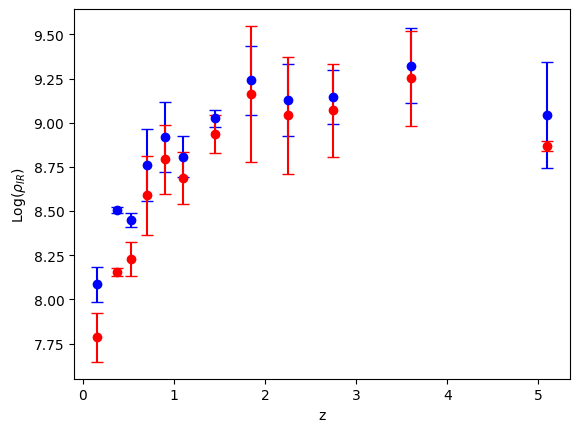

In [30]:
from scipy import integrate

# Integration bounds
lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
lower_bounds[0] = 0
upper_bounds = lower_bounds[1:] + [np.inf]

def integrate_saunders(params, param_error, sigmas):
    total_area = []
    total_area_error = []
    
    # Iterate over the parameters (redshift bins)
    for param, perr, sigma in zip(params, param_error, sigmas):
        param = np.append(param, sigma)
        perr = np.append(perr, 0)
        
        # Cumulative sum bound integrands because the quadrature algorithm doesn't work well for small areas over extremely large bounds
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        sub_area_e, sub_area_up_e, sub_area_down_e = 0, 0, 0
        for l, u in zip(lower_bounds, upper_bounds):
            
            # Perform the integration
            area_up, a_e_up = integrate.quad(saunders_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area, a_e = integrate.quad(saunders_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_down, a_e_dn = integrate.quad(saunders_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            
            # Cumulative sum
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
            sub_area_e += a_e; sub_area_up_e += a_e_up; sub_area_down_e += a_e_dn
        
        # Error propagation
        up_e = (sub_area_up + sub_area_up_e) - sub_area
        dn_e = sub_area - (sub_area_down - sub_area_down_e)
        perr = np.sqrt(a_e**2 + up_e**2 + dn_e**2)
        
        # Save the total area and error
        total_area.append(sub_area)
        total_area_error.append(perr)
    return np.array(total_area), np.array(total_area_error)

def integrate_schechter(params, param_error):
    total_area = []
    total_area_error = []
    
    # Iterate over the parameters (redshift bins)
    for param, perr in zip(params, param_error):
        
        # Cumulative sum bound integrands because the quadrature algorithm doesn't work well for small areas over extremely large bounds
        sub_area, sub_area_up, sub_area_down = 0, 0, 0
        sub_area_e, sub_area_up_e, sub_area_down_e = 0, 0, 0
        for l, u in zip(lower_bounds, upper_bounds):
            
            # Perform the integration
            area_up, a_e_up = integrate.quad(schechter_luminosity, l, u, args=tuple(param+perr)) / np.log(10)
            area, a_e = integrate.quad(schechter_luminosity, l, u, args=tuple(param)) / np.log(10)
            area_down, a_e_dn = integrate.quad(schechter_luminosity, l, u, args=tuple(np.abs(param-perr))) / np.log(10)
            
            # Cumulative sum
            sub_area += area; sub_area_up += area_up; sub_area_down += area_down
            sub_area_e += a_e; sub_area_up_e += a_e_up; sub_area_down_e += a_e_dn
        
        # Error propagation
        up_e = (sub_area_up + sub_area_up_e) - sub_area
        dn_e = sub_area - (sub_area_down - sub_area_down_e)
        perr = np.sqrt(a_e**2 + up_e**2 + dn_e**2)
        
        # Save the total area and error
        total_area.append(sub_area)
        total_area_error.append(perr)
    return np.array(total_area), np.array(total_area_error)

area, area_error = integrate_saunders(saunder_params, saunder_error, sigmas)
yerr = area / (area_error * np.log(10))
plt.errorbar(mean_z, np.log10(area), yerr=yerr, fmt='o', capsize=4, color='blue', label='Saunders')

area, area_error = integrate_schechter(schecter_params, schecter_errors)
yerr = area / (area_error * np.log(10))
plt.errorbar(mean_z, np.log10(area), yerr=yerr, fmt='o', capsize=4, color='red', label='Schechter')

plt.ylabel(r'Log($\rho_{IR}$)')
plt.xlabel('z')
plt.show()

## Luminosity Contributions

0.0 <= z < 0.3 - LD Cont - FIRGs: 68.01% - LIRGs: 23.58% - ULIRGs: 8.41% - Dominant: FIRG
0.3 <= z < 0.45 - LD Cont - FIRGs: 38.65% - LIRGs: 37.33% - ULIRGs: 24.01% - Dominant: FIRG
0.45 <= z < 0.6 - LD Cont - FIRGs: 60.22% - LIRGs: 31.19% - ULIRGs: 8.59% - Dominant: FIRG
0.6 <= z < 0.8 - LD Cont - FIRGs: 51.5% - LIRGs: 38.23% - ULIRGs: 10.26% - Dominant: FIRG
0.8 <= z < 1.0 - LD Cont - FIRGs: 34.46% - LIRGs: 47.85% - ULIRGs: 17.69% - Dominant: LIRG
1.0 <= z < 1.2 - LD Cont - FIRGs: 37.08% - LIRGs: 47.25% - ULIRGs: 15.68% - Dominant: LIRG
1.2 <= z < 1.7 - LD Cont - FIRGs: 23.86% - LIRGs: 47.25% - ULIRGs: 28.89% - Dominant: LIRG
1.7 <= z < 2.0 - LD Cont - FIRGs: 11.28% - LIRGs: 34.82% - ULIRGs: 53.9% - Dominant: ULIRG
2.0 <= z < 2.5 - LD Cont - FIRGs: 13.29% - LIRGs: 38.19% - ULIRGs: 48.52% - Dominant: ULIRG
2.5 <= z < 3.0 - LD Cont - FIRGs: 13.39% - LIRGs: 38.34% - ULIRGs: 48.28% - Dominant: ULIRG
3.0 <= z < 4.2 - LD Cont - FIRGs: 7.48% - LIRGs: 26.27% - ULIRGs: 66.25% - Dominant: ULIR

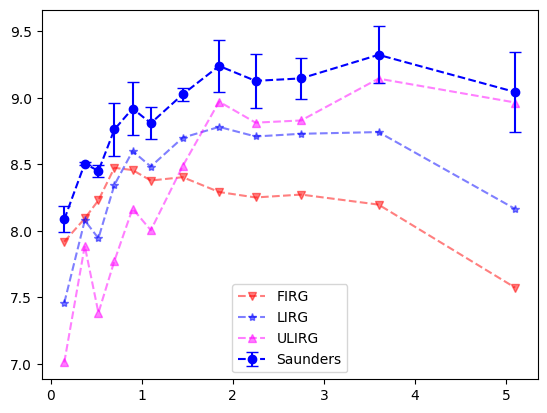

In [31]:
""" Saunder FIRG Contribution """
lower_bounds = [0,      10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]
upper_bounds = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10, 10**11]
FIRG_area, FIRG_area_error = integrate_saunders(saunder_params, saunder_error, sigmas)
plt.plot(mean_z, np.log10(FIRG_area), label='FIRG', color='red', alpha=0.5, linestyle='--', marker='v')

""" Saunder LIRG Contribution """
lower_bounds = [10**11]
upper_bounds = [10**12]
LIRG_area, LIRG_area_error = integrate_saunders(saunder_params, saunder_error, sigmas)
plt.plot(mean_z, np.log10(LIRG_area), label='LIRG', color='blue', alpha=0.5, linestyle='--', marker='*')

""" Saunder ULIRG Contribution """
lower_bounds = [10**12, 10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28]
upper_bounds = [10**14, 10**16, 10**18, 10**20, 10**22, 10**24, 10**26, 10**28, np.inf]
ULIRG_area, ULIRG_area_error = integrate_saunders(saunder_params, saunder_error, sigmas)
plt.plot(mean_z, np.log10(ULIRG_area), label='ULIRG', color='magenta', alpha=0.5, linestyle='--', marker='^')

lower_bounds = np.power(10.0, np.arange(0, 32, 2)).tolist()
lower_bounds[0] = 0
upper_bounds = lower_bounds[1:] + [np.inf]
area, area_error = integrate_saunders(saunder_params, saunder_error, sigmas)
yerr = area / (area_error * np.log(10))
plt.errorbar(mean_z, np.log10(area), yerr=yerr, fmt='o--', capsize=4, color='blue', label='Saunders')

# Relative Contributions
FIRG_area = np.round((np.array(FIRG_area) / area)*100, 2)
LIRG_area = np.round((np.array(LIRG_area) / area)*100, 2)
ULIRG_area = np.round((np.array(ULIRG_area) / area)*100, 2)
for FD, LD, UD, (z_start, z_end) in zip(FIRG_area, LIRG_area, ULIRG_area, redshift_bins):
    if FD > LD and FD > UD:
        field = 'FIRG'
    elif LD > FD and LD > UD:
        field = 'LIRG'
    else:
        field = 'ULIRG'
    print(f'{z_start} <= z < {z_end} - LD Cont - FIRGs: {FD}% - LIRGs: {LD}% - ULIRGs: {UD}% - Dominant: {field}')
    
plt.legend()
plt.show()

## Class Evolution

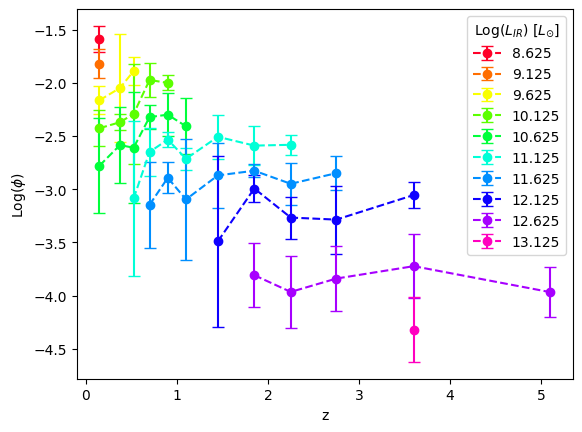

In [32]:
test_lums = np.unique(np.hstack(np.array(lum_centers, dtype=object)))[::2]
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(test_lums)))

class_phi = []
for l in test_lums:
    lum_phi = []
    for lcs, p, p_e, zc in zip(lum_centers, phi, phi_e, mean_z):
        if l in lcs:
            index = np.where(lcs == l)[0][0]
            lum_phi.append((zc, p[index], p_e[index]))
    class_phi.append(lum_phi)

for cp, col, tl in zip(class_phi, colors, test_lums):
    zx = np.array(cp)[:,0]
    py = np.array(cp)[:,1]
    ey = np.array(cp)[:,2]
    yerr = ey / (py * np.log(10))
    plt.errorbar(zx, np.log10(py), yerr=yerr, color=col, fmt='o--', capsize=4, label=f'{tl}')

plt.ylabel('Log($\phi$)')
plt.xlabel('z')
plt.legend(title='Log($L_{IR}$) [$L_{\odot}$]')
plt.show()

## Save Results

In [ ]:
file_name = 'fits/BIG_ZFOURGE_TOTAL'
np.savez(file_name,
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object),
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    s=np.array(sigmas, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object))